In [173]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import requests
import datetime
import os
import holidays
import seaborn as sns
import matplotlib.pyplot as plt



In [135]:
# Define possible file paths
path1 = r"C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\raw\Energy Demand Forcasting.csv"
path2 = r"C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\Energy Demand Forcasting.csv"

# Check which path exists and read CSV
if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [136]:
# STEP 2 — Define location (latitude, longitude)
# Example: Odisha, India

latitude = 20.9517
longitude = 85.0985

In [137]:
data

,date,megawatthours
0,2015-07-01 05:00:00,162827
1,2015-07-01 06:00:00,335153
2,2015-07-01 07:00:00,333837
3,2015-07-01 08:00:00,398386
4,2015-07-01 09:00:00,388954
...,...,...
58931,2022-03-21 16:00:00,433344
58932,2022-03-21 17:00:00,429156
58933,2022-03-21 18:00:00,426496
58934,2022-03-21 19:00:00,423393


In [138]:
data.tail()

,date,megawatthours
58931,2022-03-21 16:00:00,433344
58932,2022-03-21 17:00:00,429156
58933,2022-03-21 18:00:00,426496
58934,2022-03-21 19:00:00,423393
58935,2022-03-21 20:00:00,420157


In [139]:
data.shape


(58936, 2)

In [143]:
data = data.sort_values("date")

In [146]:
data['date'] = pd.to_datetime(data['date'])

In [147]:
start_date = data['date'].min().strftime("%Y-%m-%d")
end_date = data['date'].max().strftime("%Y-%m-%d")

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=temperature_2m,relative_humidity_2m"
)

In [148]:
start_date

'2015-07-01'

In [149]:
end_date

'2022-03-21'

In [150]:
response = requests.get(url)

In [151]:
weather_df = response.json()

In [152]:
weather_data = pd.DataFrame({
    "datetime": pd.to_datetime(weather_df["hourly"]["time"]),
    "temperature": weather_df["hourly"]["temperature_2m"],
    "humidity": weather_df["hourly"]["relative_humidity_2m"]
})

In [159]:
weather_data

,datetime,temperature,humidity
0,2015-07-01 00:00:00,24.8,95
1,2015-07-01 01:00:00,25.1,94
2,2015-07-01 02:00:00,25.8,90
3,2015-07-01 03:00:00,26.2,87
4,2015-07-01 04:00:00,27.4,82
...,...,...,...
58939,2022-03-21 19:00:00,24.1,77
58940,2022-03-21 20:00:00,23.8,84
58941,2022-03-21 21:00:00,24.2,86
58942,2022-03-21 22:00:00,22.6,94


In [160]:
df1 = data['megawatthours'].rename('megawatt_hours')

In [161]:
df = pd.concat([weather_data, df1], axis=1)

In [162]:
df

,datetime,temperature,humidity,megawatt_hours
0,2015-07-01 00:00:00,24.8,95,162827.0
1,2015-07-01 01:00:00,25.1,94,335153.0
2,2015-07-01 02:00:00,25.8,90,333837.0
3,2015-07-01 03:00:00,26.2,87,398386.0
4,2015-07-01 04:00:00,27.4,82,388954.0
...,...,...,...,...
58939,2022-03-21 19:00:00,24.1,77,NaN
58940,2022-03-21 20:00:00,23.8,84,NaN
58941,2022-03-21 21:00:00,24.2,86,NaN
58942,2022-03-21 22:00:00,22.6,94,NaN


In [163]:
print(df.isnull().sum())
df.dropna(inplace=True)

datetime          0
temperature       0
humidity          0
megawatt_hours    8
dtype: int64


In [164]:
# ===== CORE TIME FEATURES =====
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_month'] = df['datetime'].dt.day
df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.quarter
df['year'] = df['datetime'].dt.year
df['day_of_year'] = df['datetime'].dt.dayofyear
#df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# ===== CYCLIC ENCODINGS =====
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['lag_1'] = df['megawatt_hours'].shift(1)
df['lag_24'] = df['megawatt_hours'].shift(24)
df['lag_168'] = df['megawatt_hours'].shift(168)
df['rolling_mean_24'] = df['megawatt_hours'].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df['megawatt_hours'].shift(1).rolling(window=24).std()

In [170]:
df.head(5)

,datetime,temperature,humidity,megawatt_hours,hour,day_of_week,day_of_month,week_of_year,month,quarter,...,hour_cos,month_sin,month_cos,dayofweek_sin,dayofweek_cos,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24
0,2015-07-01 00:00:00,24.8,95,162827.0,0,2,1,27,7,3,...,1.000000,-0.5,-0.866025,0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN
1,2015-07-01 01:00:00,25.1,94,335153.0,1,2,1,27,7,3,...,0.965926,-0.5,-0.866025,0.974928,-0.222521,162827.0,NaN,NaN,NaN,NaN
2,2015-07-01 02:00:00,25.8,90,333837.0,2,2,1,27,7,3,...,0.866025,-0.5,-0.866025,0.974928,-0.222521,335153.0,NaN,NaN,NaN,NaN
3,2015-07-01 03:00:00,26.2,87,398386.0,3,2,1,27,7,3,...,0.707107,-0.5,-0.866025,0.974928,-0.222521,333837.0,NaN,NaN,NaN,NaN
4,2015-07-01 04:00:00,27.4,82,388954.0,4,2,1,27,7,3,...,0.500000,-0.5,-0.866025,0.974928,-0.222521,398386.0,NaN,NaN,NaN,NaN


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'megawatt_hours'}>,
        <Axes: title={'center': 'hour'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'day_of_month'}>,
        <Axes: title={'center': 'week_of_year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'quarter'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'day_of_year'}>,
        <Axes: title={'center': 'hour_sin'}>,
        <Axes: title={'center': 'hour_cos'}>,
        <Axes: title={'center': 'month_sin'}>],
       [<Axes: title={'center': 'month_cos'}>,
        <Axes: title={'center': 'dayofweek_sin'}>,
        <Axes: title={'center': 'dayofweek_cos'}>,
        <Axes: title={'center': 'lag_1'}>,
        <Axes: title={'center': 'lag_24'}>],
       [<Axes: title={'center': 'lag_168'}>,
        <Axes

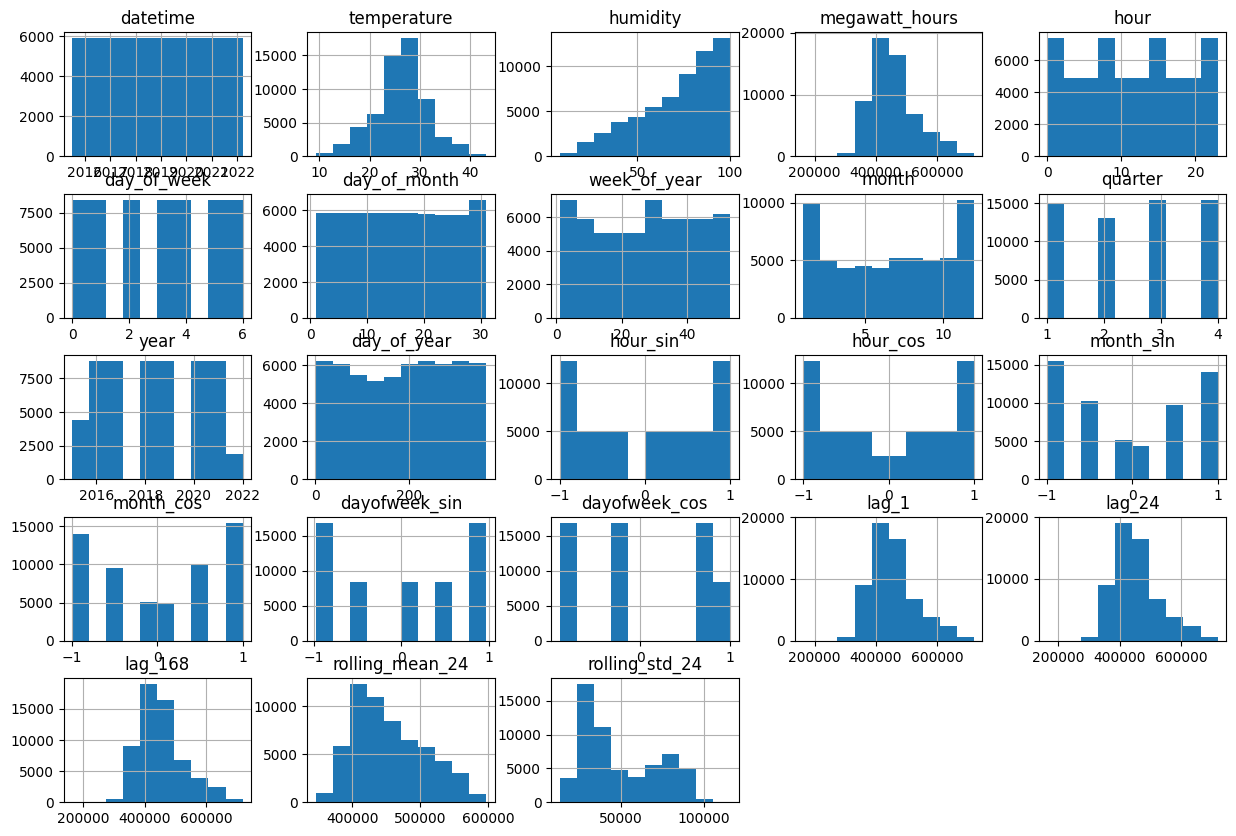

In [166]:
df.hist(figsize=(15, 10))

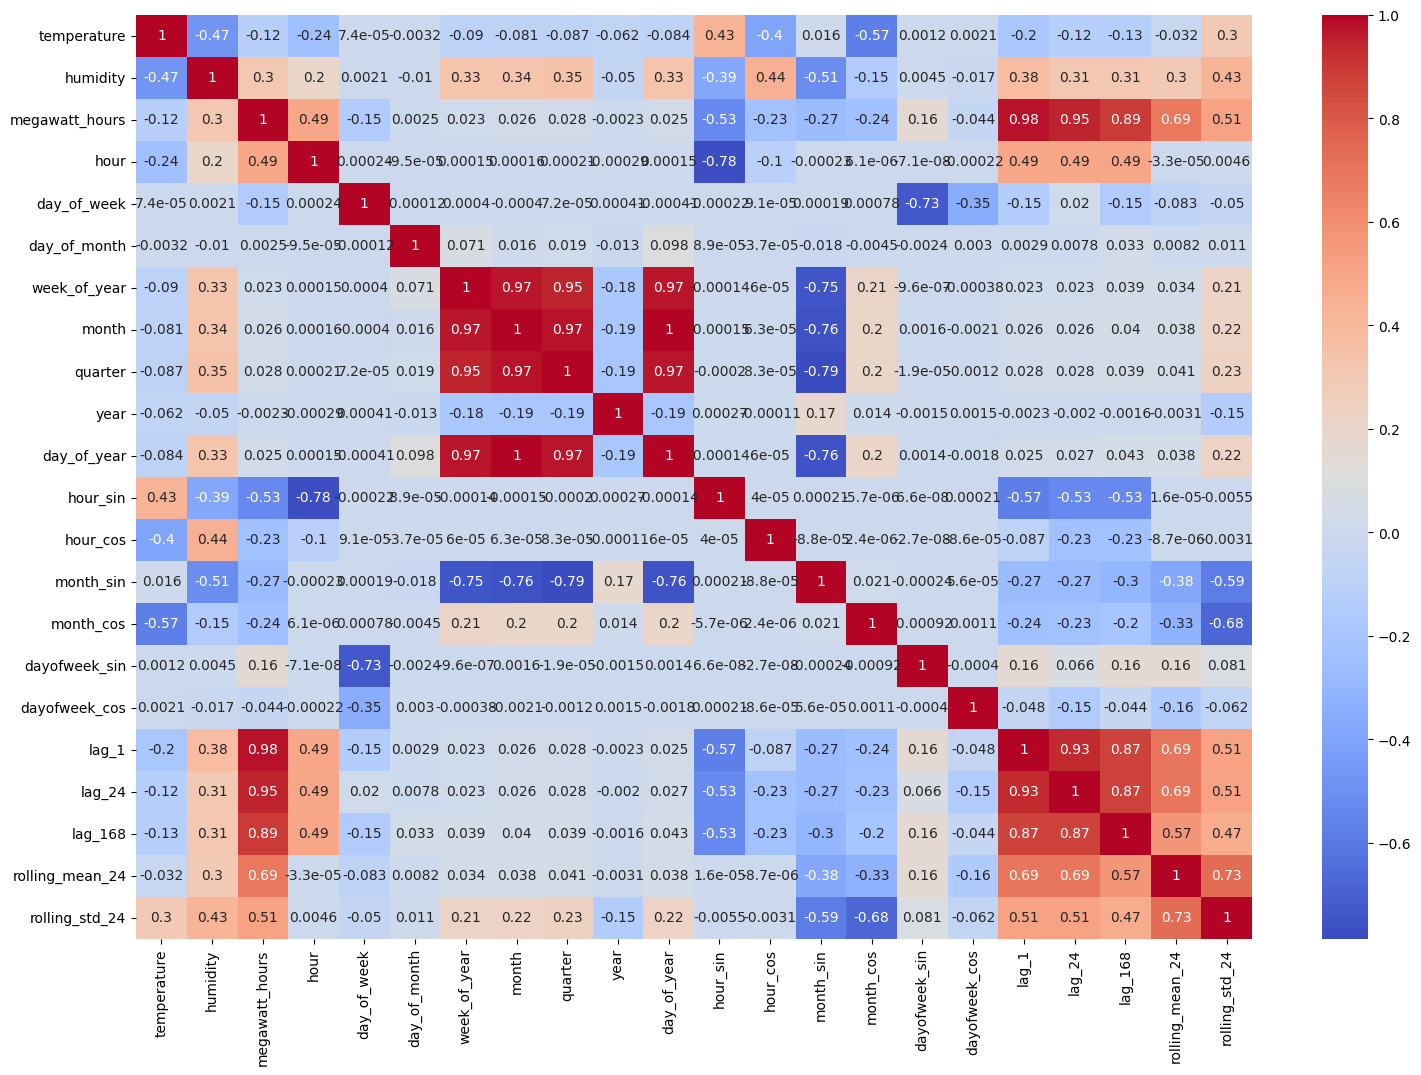

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))  # Adjust width and height as needed
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

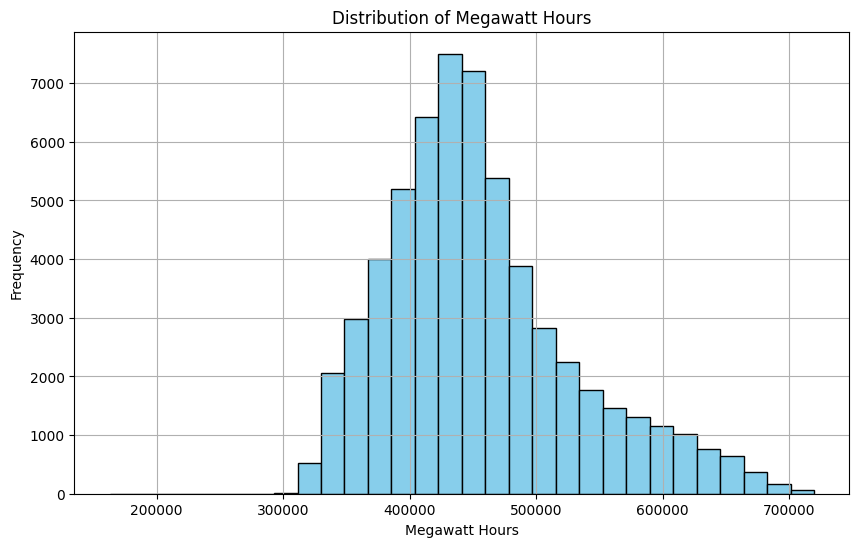

In [171]:
plt.figure(figsize=(10, 6))
plt.hist(df['megawatt_hours'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Megawatt Hours')
plt.xlabel('Megawatt Hours')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\TPWODL\AppData\Local\Temp\ipykernel_16696\962469038.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['megawatt_hours'], shade=True, color='purple')


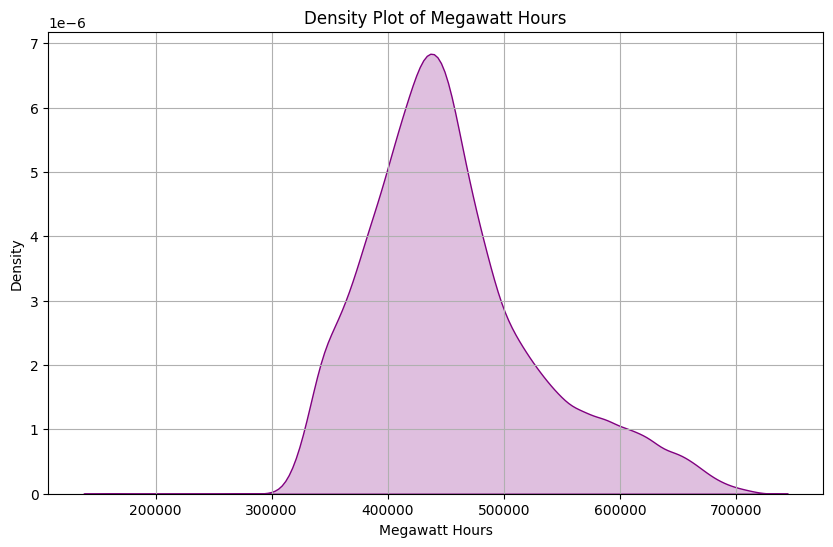

In [172]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['megawatt_hours'], shade=True, color='purple')
plt.title('Density Plot of Megawatt Hours')
plt.xlabel('Megawatt Hours')
plt.ylabel('Density')
plt.grid(True)
plt.show()

✓ Time series plot saved as 'xgb_time_series_plot.png'


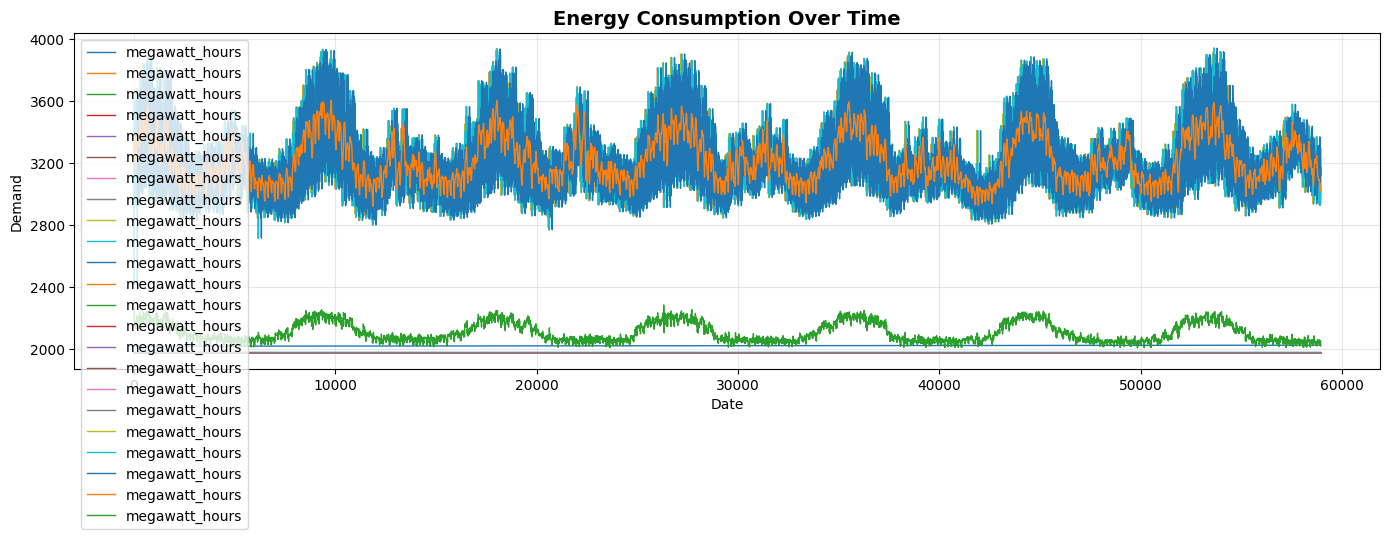

In [175]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df, label='megawatt_hours', linewidth=1)
plt.title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('xgb_time_series_plot.png', dpi=300)
print("✓ Time series plot saved as 'xgb_time_series_plot.png'")
plt.show()